In [1]:
import codecs
import glob
import pickle

import xmltodict
from gensim import corpora
from nltk import download
from nltk import word_tokenize
# Import and download stopwords from NLTK.
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
# exclude = list(string.punctuation) 
exclude = ['\'s', '\'\'', '``', '–', '‘a', '--', '...']
print(exclude)
lemma = WordNetLemmatizer()

download('stopwords')  # Download stopwords list.
stop_words = stopwords.words('english')
download('punkt')  # Download data for tokenizer.

def preprocess(doc):
    doc = doc.lower()  # Lower the text.
    doc = word_tokenize(doc)  # Split into words.
    doc = [w for w in doc if not w in stop_words]  # Remove stopwords.
    doc = [w for w in doc if w.isalpha()]  # Remove numbers and punctuation.
    doc = [w for w in doc if w not in exclude] # EOS specific
    doc = [lemma.lemmatize(word) for word in doc] # to normalize
    return doc

["'s", "''", '``', '–', '‘a', '--', '...']
[nltk_data] Downloading package stopwords to /home/sonic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sonic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
%%time 


path = "/home/sonic/sonic/EOS_DATA/XML_Export_6-8-2015/ContainingTerms/English/*/*.xml"
# path = "data/Karbala/*.xml"
doc_filepath = 'data/eos/eos_tokenize_all.p'

eos_corpus = []
if 0 == 1:

    for fname in glob.glob(path):

        with codecs.open(fname, encoding='utf_8') as doc_file:
            # print(fname)
            try:
                doc = xmltodict.parse(doc_file.read())
                # print(doc['Document']['Id'])
                # print(doc['Document']['Text'])
                eos_corpus.append(preprocess(doc['Document']['Text']))
            except Exception as e: 
                print(e)

    # Remove empty documents         
    # Justify this trimming ? the upper bound screw with the histogram.
    eos_corpus = [doc for doc in eos_corpus if len(doc) <= 3000]

    print(u'''Text from {:,} documents written to the new txt file.'''.format(len(eos_corpus)))
        
    pickle.dump(eos_corpus, open(doc_filepath, "wb"))
    
else:
    eos_corpus = pickle.load(open(doc_filepath, "rb"))

CPU times: user 19.9 s, sys: 2.61 s, total: 22.5 s
Wall time: 22.6 s


0
464817
2997
0


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.5/dist-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: pyplot.hold is de

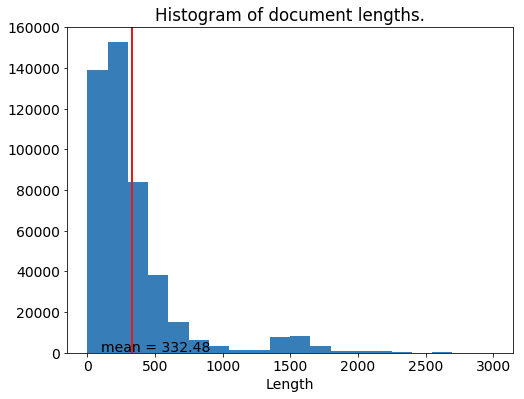

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

# Document lengths.
lens = [len(doc) for doc in eos_corpus]

print(len(eos_corpus) - len(eos_corpus))
print(len(lens))

print(len(max(eos_corpus, key=len)))
print(len(min(eos_corpus, key=len)))

# Plot.
plt.rc('figure', figsize=(8, 6))
plt.rc('font', size=14)
plt.rc('lines', linewidth=2)
plt.rc('axes', color_cycle=('#377eb8', '#e41a1c', '#4daf4a',
                            '#984ea3', '#ff7f00', '#ffff33'))
# Histogram.
plt.hist(lens, bins=20)
plt.hold(True)
# Average length.
avg_len = sum(lens) / float(len(lens))
plt.axvline(avg_len, color='#e41a1c')
plt.hold(False)
plt.title('Histogram of document lengths.')
plt.xlabel('Length')
plt.text(100, 800, 'mean = %.2f' % avg_len)
plt.show()

In [5]:
%%time


# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(eos_corpus)
dictionary.save_as_text('data/eos/dictionary_EOS.txt')

CPU times: user 1min 55s, sys: 96 ms, total: 1min 55s
Wall time: 1min 55s


In [6]:
%%time


# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in eos_corpus]
corpora.MmCorpus.serialize('data/eos/processed_corpus_EOS.mm', corpus)

CPU times: user 3min 14s, sys: 4.65 s, total: 3min 19s
Wall time: 3min 19s


# Ngrams